# AutoEncoders:

## How Does MP4 Compression Work?


Data Compression is a crucial aspect for Information management. Compression is everywhere! Everyone has seen .mp4 files before, but what does this compression format do? Instead of storing every frame as an image and storing all the images, MP4 will create reference frames every few frames throughout the video. Then, instead of storing all the pixel values of frames after the reference frame, it will only store what pixels changed from the reference frame. By doing this, if there is not a lot of movement in the frame, all that redundant data can be thrown out for the compression to occur. Although our filesize has now gone down considerably, when we go to play back the video, the computer needs to perform computations of taking every reference frame and then adding the changes to it to display the future frames. There is a ton more that goes into this (and you can explore some of this [here!](https://blog.video.ibm.com/streaming-video-tips/keyframes-interframe-video-compression/)) but for now just use this as an analogy for why we love AutoEnoders!

## What is an AutoEncoder?

AutoEncoders are kind of the same thing. In data, typically there is a lot of redundant information (correlated features). There are repeating patterns that don't need to be stored, but can be extrapolated from a compressed state. For example, if I gave you an image with random chunks of it missing, could you fill in the gaps? Of course! And we will take a look at these type of gap-filling architectures in the future, but for now lets explore the basics. More specifically, AutoEncoders fall into a category of Unsupervised Dimensionality Reduction Algorithms.

### Curse of Dimensionality
We typically describe data by the number of features (or dimensions) it has, but we fall into a problem coined by Richard Bellman, the Curse of Dimensionality. High dimensional data causes a lot of problems:
- Lack of interpretability, we cannot visualize more than 3 dimensions at a time!
- Sparsity, your data may have a super high dimensionality, but may only occupy small pockets of that vector space.
- Complexity, as we increase the number of features, the complexity to train models increase
- P > N problem, if you have more features than samples of data, your model may be underdetermined or unsolveable! Genomics has this problem typically, where there may be a few hundred samples and thousands of features.


### PCA to the Rescue!

<div>
<img src="https://github.com/HarshTomar1234/Machine-and-Deep-Learning-NLP/blob/main/AutoEncoders/imgs/pca_visual.png?raw=true" width="1000"/>
</div>


You have probably heared of Principal Component Analysis (PCA) before which attempts to solve this exact problem, and seems to work really well in practice. The high-level intuition of PCA is, lets pretend you have dimensions $x_1, x_2$ and some data that exists in this space. What we want to do is come up with a new set of axis called $PC_1, PC_2$ (principal component 1 and 2) where each axis represents a direction of highest variance, and all our axis remain orthogonal to each other (just like regular axis).

In the visual above, we have some green and blue dots and we want to train a classifier, but the complexity of two dimensions is too high (just pretend). So we use PCA, which will draw our $PC_1$, the direction of highest spread (variance) in the dataset and $PC_2$, the second direction of highest variance that is also orthogonal to the first, and orthogonal axis is centered at the mean of our $x_1, x_2$ features. We then throw away $PC_2$ and project all the data onto $PC_1$, thus leaving us with only a single dimension (a line). In this line, we can still see a separation between our green and blue dots, therefore a classifier on this one feature will probably be pretty close to training one on the original $x_1, x_2$ features! If you then have a large number of correlated features in your dataset, you can compress them down into just a few features.

This works really great in practice actually, but there are two limitations to PCA:

- The princpal components are linear
- Each principal component has to be orthogonal to each other

Data can be complex, messy, and definitely non-linear, so how do Autoencoders address this?

### AutoEncoders are Non-Linear PCA

<div>
<img src="https://github.com/HarshTomar1234/Machine-and-Deep-Learning-NLP/blob/main/AutoEncoders/imgs/autoencoder_visual.png?raw=true" width="800"/>
</div>

Instead of performing a linear compression via PCA, we can force a Neural Network to compress data down (the encoder) and then use the compressed form to recontruct the original data (the decoder). The forces the model to create a low dimensional representation that is good enough to reconstruct the original data from. The typical form for the autoencoder is this hourglass shape, where the encoder and decoder are mirror images of each other with the most restriction of data flow in the middle (typically called the latent space of the model). It is important for the bottleneck to be sufficiently small, otherwise the model will just learn an identity function. To train this model, all we need to do is pass in data, and then compute a reconstruction loss on the other end to the input.

The architecture you use for the compression and decompression is totally up to you! For images, starting with simple MNIST for now, we will explore Linear compression and then Convolution compression. What I want to look into here is how the AutoEncoder learns the latent space over time. For visualizing the embeddings, we will compress MNIST down to just 2 Number! That means we are going from a 28 x 28 = 784 pixels to just 2 numbers, a very high compression factor.

Celluloid is a Python library that simplifies the creation of animations in Matplotlib. It's particularly useful for visualizing data that changes over time or iterative processes.

Key features of Celluloid:

1. **Easy animation creation**: It provides a Camera object that captures matplotlib figures as frames, making the animation process much simpler than using matplotlib's animation functions directly.

2. **Simple API**: You can create animations with just a few lines of code instead of dealing with matplotlib's more complex animation API.

3. **Common use cases**:
   - Visualizing training progress in machine learning
   - Showing how algorithms evolve step by step
   - Creating animated data visualizations
   - Displaying changes in latent spaces (as hinted in our code)



In [1]:
!pip install celluloid

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Stuff to Visualize the Latent Space ###
from celluloid import Camera
from IPython.display import HTML

### Seed Everything ###
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

### GENERATE ANIMATIONS ###
generate_anim = False

# Install celluloid if not already installed
!pip install celluloid

# Define transforms - resizing to 32x32
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Download the training set
train_set = MNIST(root='/content/data/mnist/', train=True, download=True, transform=transform)

# Download the test set
test_set = MNIST(root='/content/data/mnist/', train=False, download=True, transform=transform)

### SET DEVICE ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.20MB/s]

Using device: cuda


# Vanilla Autoencoders and Convolutional Autoencoders

Let me explain both types of autoencoders in detail, along with their advantages and disadvantages.

## Vanilla Autoencoder

A vanilla autoencoder is a type of neural network that learns to encode input data into a lower-dimensional representation and then decode it back to reconstruct the original input.

### Architecture

1. **Encoder**: Consists of fully connected (dense) layers that progressively reduce the dimensionality of the input data
2. **Bottleneck (Latent Space)**: The compressed representation of the input data
3. **Decoder**: Consists of fully connected layers that progressively increase dimensionality to reconstruct the original input

### Training Process

Vanilla autoencoders are trained to minimize reconstruction loss—typically mean squared error (MSE) between the input and output. The network learns to extract the most important features needed for reconstruction.

### Advantages

1. **Simple structure**: Easy to implement and understand
2. **Effective dimensionality reduction**: Can compress data into meaningful lower-dimensional representations
3. **Unsupervised learning**: Doesn't require labeled data
4. **Feature extraction**: The bottleneck layer can be used as a feature extractor for downstream tasks
5. **Data generation**: Once trained, can generate new samples by feeding novel latent vectors to the decoder
6. **Noise reduction**: Can be trained to reconstruct clean data from noisy inputs (denoising autoencoder variant)

### Disadvantages

1. **Fully connected architecture**: Inefficient for high-dimensional data like images
2. **Loss of spatial information**: Doesn't maintain spatial relationships in data
3. **Scalability issues**: Number of parameters grows quickly with input size
4. **Overfitting risk**: May memorize training data instead of learning useful representations
5. **Limited representational capacity**: May struggle with complex patterns
6. **Blurry reconstructions**: Often produces smoothed outputs when dealing with images

## Convolutional Autoencoder

A convolutional autoencoder applies convolutional neural network (CNN) principles to the autoencoder framework, making it particularly suited for image data.

### Architecture

1. **Encoder**: Uses convolutional layers with pooling operations to reduce spatial dimensions
2. **Bottleneck (Latent Space)**: Compressed representation as feature maps or flattened vector
3. **Decoder**: Uses transposed convolution (or upsampling + convolution) to restore original dimensions

### Advantages

1. **Parameter efficiency**: Shares weights across spatial locations, requiring fewer parameters
2. **Spatial awareness**: Preserves spatial relationships in the data
3. **Translation invariance**: Can recognize patterns regardless of their position
4. **Hierarchical feature learning**: Earlier layers capture low-level features (edges, textures), while deeper layers learn more abstract concepts
5. **Better for visual data**: Significantly outperforms vanilla autoencoders on images
6. **Sharper reconstructions**: Preserves more detail in reconstructed outputs
7. **Effective feature maps**: Intermediate activations are meaningful and interpretable
8. **Scalability**: Can handle large images more effectively

### Disadvantages

1. **Architectural complexity**: More complex to design and tune
2. **Computationally intensive**: Convolutional operations are more resource-demanding
3. **Hyperparameter sensitivity**: Performance depends on filter sizes, strides, padding choices
4. **Still limited by bottleneck capacity**: Too small a latent space limits reconstruction quality
5. **Potential checkerboard artifacts**: Can produce grid-like patterns when using transposed convolutions
6. **Less effective for non-grid data**: Not ideal for tabular or sequence data

## Practical Applications

### Vanilla Autoencoders
- Dimensionality reduction for tabular data
- Anomaly detection in simple datasets
- Basic feature extraction
- Noise reduction in 1D signals

### Convolutional Autoencoders
- Image compression
- Image denoising and restoration
- Feature extraction for computer vision tasks
- Transfer learning
- Medical image enhancement
- Anomaly detection in images
- Image inpainting (filling missing parts)
- Data augmentation

## Implementation Considerations

### Vanilla Autoencoders
- Simple MLP layers
- Typically use ReLU or sigmoid activations
- Requires flattening for image inputs
- Works with various loss functions (MSE, binary cross-entropy)

### Convolutional Autoencoders
- Requires careful design of convolutional/deconvolutional architectures
- May use skip connections (like U-Net) to preserve details
- Often incorporates batch normalization
- Can benefit from pretrained weights for encoder

## Recent Advancements

Both types have evolved into more sophisticated variants:
- Variational Autoencoders (VAEs): Add probabilistic components
- Adversarial Autoencoders: Incorporate adversarial training
- Sparse Autoencoders: Enforce sparsity in activations
- Contractive Autoencoders: Make encodings robust to input variations

The choice between vanilla and convolutional autoencoders ultimately depends on your data type, computational resources, and specific application requirements.

## Basic NonLinear AutoEncoder

Everything about this Nonlinear AutoEncoder is arbritrary. All I care about is we have 28 x 28 inputs going in and 28 x 28 inputs coming out. All the layers are just reasonable guesses for hidden layers, and we included ReLU nonlinearity. Also, the images we are trying to predict have been scaled between 0 and 1, so we want the output of our model to be the same, so that is why we have a sigmoid placed at the end!

In [3]:
class VanillaAutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid()
        )

    def forward_enc(self, x):
        return self.encoder(x)

    def forward_dec(self, x):
        x = self.decoder(x)
        x = x.reshape(-1,1,32,32)
        return x

    def forward(self, x):

        batch, channels, height, width = x.shape

        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        enc = self.forward_enc(x)

        ### Pass Through Decoder ###
        dec = self.forward_dec(enc)

        return enc, dec



### Super Simple Training Script

There isn't anything fancy going on in this training script. The onlt things we will pass in is the model we want to train, the datasets, batch size we want to use, as well as the number of training iterations and how often we want to evaluate the model with the testing data. The only extra thing added in is when we evaluate the model, we will store all the encoded images so we can plot the encodings over the duration of the training later!

In [4]:
def train(model,
          train_set,
          test_set,
          batch_size,
          training_iterations,
          evaluation_iterations,
          verbose=False):

    print("Training Model!")
    print(model)

    ### Set the Device ###
    device = "cuda" if torch.cuda.is_available() else "cpu"

    ### Define the Model and Place on Device ###
    model = model.to(device)

    ### Set the Dataloaders ###
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    ### Set the Optimizer ###
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    ### Some List for logging ###
    train_loss = []
    evaluation_loss = []
    train_losses = []
    evaluation_losses = []

    ### List to store Encoded Data when Evaluating ###
    encoded_data_per_eval = []

    ### Create a Progress Bar ###
    pbar = tqdm(range(training_iterations))

    train = True
    step_counter = 0
    while train:

        for images, labels in trainloader:

            images = images.to(device) # not using labels because giving image and getting image as output so basically an unsupervised learning...
            encoded, reconstruction = model(images)

            ### Simple MSE Loss ###
            loss = torch.mean((images - reconstruction)**2)
            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:

                model.eval()
                encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)
                    encoded, reconstruction = model(images)
                    loss = torch.mean((images - reconstruction)**2)
                    evaluation_loss.append(loss.item())

                    ### Store the Encoded Image with their Labels ###
                    encoded, labels = encoded.cpu().flatten(1), labels.reshape(-1,1)
                    encoded_evaluations.append(torch.cat((encoded, labels), axis=-1))

                ### Store All Testing Encoded Images ###
                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())

                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                if verbose:
                    print("Training Loss", train_loss)
                    print("Evaluation Loss", evaluation_loss)

                ### Reset For Next Evaluation ###
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)

            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    ### Store All Encoded Data as Numpy Arrays for each Eval Iteration ###
    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])

    return model, train_losses, evaluation_losses, encoded_data_per_eval

vanilla_model = VanillaAutoEncoder(bottleneck_size=2)
vanilla_model, train_losses, evaluation_losses, vanilla_encoded_data = train(vanilla_model,
                                                                             train_set,
                                                                             test_set,
                                                                             batch_size=64,                                                                    training_iterations=25000,
                                                                             evaluation_iterations=250)

Training Model!
VanillaAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1024, bias=True)
    (7): Sigmoid()
  )
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.02855682736635208
Final Evaluation Loss 0.02894721059187962


### Plotting the Emedding Space Through Training ###

We can now write a function that can take in the **encoded_data_per_eval** from our output of the training, and then create an animation of the embeddings space to see how the Neural Network Learns.

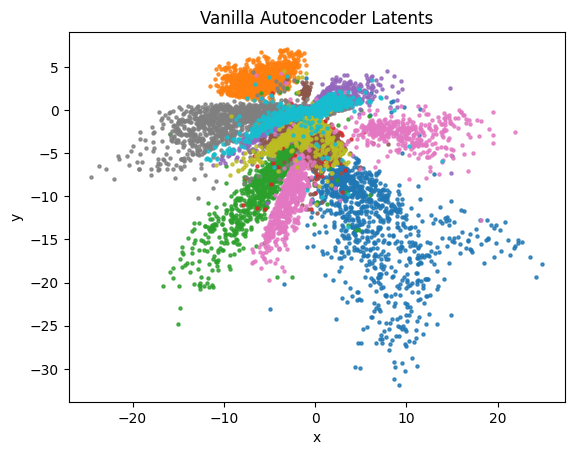

In [5]:
def build_embedding_animation(encoded_data_per_eval, iterations_per_eval=100):

    fig, ax = plt.subplots()

    camera = Camera(fig)

    for idx, encoding in enumerate(encoded_data_per_eval):

        encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
        encoding = encoding.sort_values(by="class")
        encoding["class"] = encoding["class"].astype(int).astype(str)

        for grouper, group in encoding.groupby("class"):
            plt.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

        ax.text(0.4, 1.01, f"Step {idx*iterations_per_eval}", transform=ax.transAxes, fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        camera.snap()

    plt.close()
    anim = camera.animate(blit=True)

    return anim

def build_embedding_plot(encoding, title):
    encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
    encoding = encoding.sort_values(by="class")
    encoding["class"] = encoding["class"].astype(int).astype(str)

    for grouper, group in encoding.groupby("class"):
        plt.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


if generate_anim:
    anim = build_embedding_visual(vanilla_encoded_data)
    HTML(anim.to_jshtml())

else:
    build_embedding_plot(vanilla_encoded_data[-1], "Vanilla Autoencoder Latents")




### Just for Fun, a Linear Autoencoder!

Although this isnt exactly PCA (because we have no orthogonality restrictions on the components), this should look somewhat similar to what PCA produces!


In [6]:
class LinearAutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(32*32, bottleneck_size),
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 32*32),
        )

    def forward(self, x):

        batch, channels, height, width = x.shape

        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        enc = self.encoder(x)

        ### Pass Through Decoder ###
        dec = self.decoder(enc)

        ### Put Decoded Image Back to Original Shape ###
        dec = dec.reshape(batch, channels, height, width)

        return enc, dec

Training Model!
LinearAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
  )
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.04622607636451721
Final Evaluation Loss 0.0461905953373499


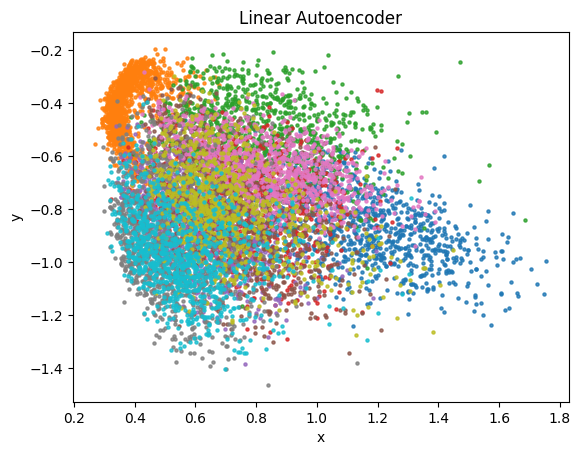

In [7]:
linear_model = LinearAutoEncoder(bottleneck_size=2)
model, train_losses, evaluation_losses, linear_encoded_data = train(linear_model,
                                                                    train_set,
                                                                    test_set,
                                                                    batch_size=64,
                                                                    training_iterations=25000,
                                                                    evaluation_iterations=250)
if generate_anim:
    anim = build_embedding_visual(linear_encoded_data)
    HTML(anim.to_jshtml())

else:
    build_embedding_plot(linear_encoded_data[-1], "Linear Autoencoder")


### Lets Compare to PCA!

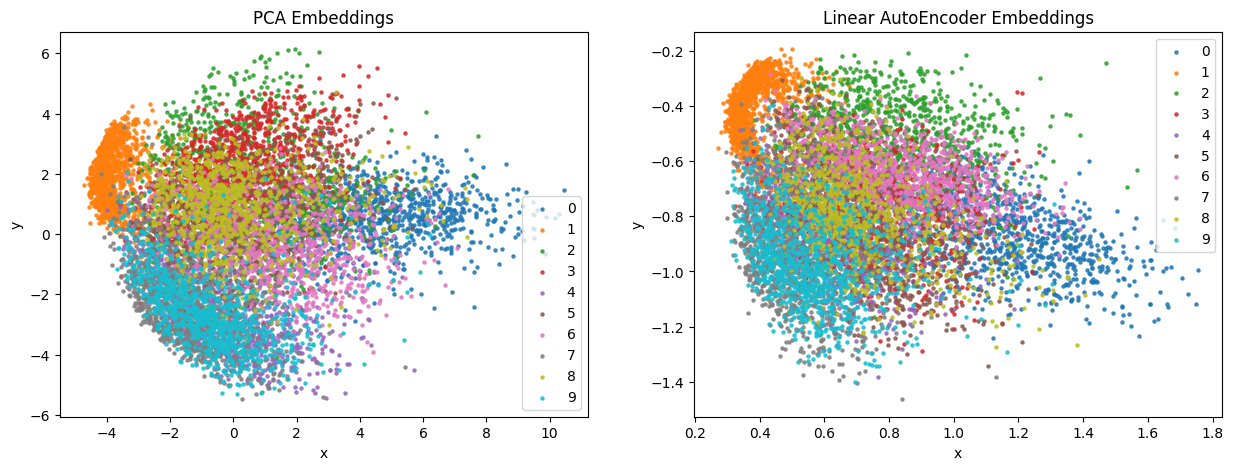

In [15]:
data = np.array(torch.cat([d[0].flatten(1) for d in test_set], dim=0))
labels = np.array([d[1] for d in test_set]).reshape(-1,1)

### PCA Encodings ###
pca = PCA(n_components=2)
pca_encoding = pca.fit_transform(data)
pca_encoding = np.concatenate((pca_encoding, labels), axis=-1)
pca_encoding = pd.DataFrame(pca_encoding, columns=["x", "y", "class"])
pca_encoding = pca_encoding.sort_values(by="class")
pca_encoding["class"] = pca_encoding["class"].astype(int).astype(str)


### Grab Last Linear Encodings ###
linauto_encoding = linear_encoded_data[-1]
linauto_encoding = pd.DataFrame(linauto_encoding, columns=["x", "y", "class"])
linauto_encoding = linauto_encoding.sort_values(by="class")
linauto_encoding["class"] = linauto_encoding["class"].astype(int).astype(str)


### Lets Plot it All Now! ###
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

### Plot PCA Plot ###
for grouper, group in pca_encoding.groupby("class"):
    ax1.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("PCA Embeddings")

for grouper, group in linauto_encoding.groupby("class"):
    ax2.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax2.legend()
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Linear AutoEncoder Embeddings")

plt.show()

These actually look pretty similar! Disregarding the scale, the Linear Autoencoder is a seems like a rotated version of the PCA embeddings. (The Linear AutoEncoder can also change every time you run it just due to randomness of training). If they look similar, then what do the weight vectors of each principal component look like? Are they orthogonal?

In [9]:
### Principal Component Vectors ###
pc_1, pc_2 = torch.tensor(pca.components_[0]), torch.tensor(pca.components_[1])
print("Angle Between PCA Principal Components", torch.rad2deg(torch.acos(torch.dot(pc_1, pc_2))).item())

### Linear AutoEncoder Projection Vectors ###
model_weights = model.encoder[0].weight

weight_vector_1, weight_vector_2 = model_weights[0].cpu(), model_weights[1].cpu()
weight_vector_1 = weight_vector_1 / torch.norm(weight_vector_1)
weight_vector_2 = weight_vector_2 / torch.norm(weight_vector_2)

print("Angle Between AutoEncoder Vectors", torch.rad2deg(torch.acos(torch.dot(weight_vector_1, weight_vector_2))).item())

Angle Between PCA Principal Components 90.0
Angle Between AutoEncoder Vectors 88.40234375


It looks like the best projection vectors the model could create were almost Orthogonal! This shows that AutoEncoders can closely approximate PCA by using Gradient Descent rather than expensive eigenvalue decompositions on large datasets.

# Downsampling(convolution) vs Upsampling(Deconvolution)

```
rand = torch.randn(2, 3, 64, 64)
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size = 3, stride= 2, padding=1)
deconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)
print(conv(rand).shape)
print(deconv(conv(rand)).shape)
```


Deconvolution (also called transposed convolution or fractionally strided convolution) is essentially the reverse operation of a normal convolution. Let me break down how it works:

## Convolution vs. Deconvolution

### Regular Convolution (nn.Conv2d):
- Takes an input and reduces its spatial dimensions (when stride > 1)
- Maps from a larger spatial dimension to a smaller one
- In our example: `Conv2d(3, 3, kernel_size=3, stride=2, padding=1)` reduces spatial dimensions by half

### Deconvolution (nn.ConvTranspose2d):
- Does the opposite: increases spatial dimensions
- Maps from a smaller spatial dimension to a larger one
- In our example: `ConvTranspose2d(3, 3, kernel_size=3, stride=2, padding=1, output_padding=1)` doubles spatial dimensions

## How Deconvolution Works

1. **Not a true inverse**: Despite the name, it's not mathematically the exact inverse of convolution, but rather a way to go in the opposite direction.

2. **Process**:
   - It inserts zeros between input elements (determined by stride)
   - Applies a regular convolution operation with the kernel
   - The output_padding parameter adds extra padding to the output

3. **Parameters explained**:
   - `in_channels=3, out_channels=3`: Number of input and output feature maps
   - `kernel_size=3`: Size of the convolutional kernel
   - `stride=2`: Upsampling factor (multiplies spatial dimensions by 2)
   - `padding=1`: Zero-padding added to input
   - `output_padding=1`: Additional padding to adjust output size precisely

## In our code example:
```python
rand = torch.randn(2, 3, 64, 64)  # Batch of 2, 3 channels, 64×64 images
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)
deconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

print(conv(rand).shape)  # Would output: torch.Size([2, 3, 32, 32])
print(deconv(conv(rand)).shape)  # Would output: torch.Size([2, 3, 64, 64])
```

The convolution reduces the 64×64 images to 32×32, and then the deconvolution brings them back to 64×64.

## Common applications:
- Autoencoders: Going from compressed representation back to original size
- GANs: Generating high-resolution images from lower-dimensional latent vectors
- Semantic segmentation: Upsampling feature maps to match input resolution

The `output_padding=1` is critical in our example because without it, the deconvolution wouldn't produce exactly 64×64 output due to rounding in the calculations.


#### Output Padding parameter
The output padding is important because of how stride and padding interact in transposed convolutions. Let me explain why we get [2, 3, 63, 63] without output_padding:

### Why output_padding is needed

When we use a stride > 1 in a regular convolution, we lose spatial information. For example, with stride=2, we:
1. Skip every other pixel
2. Round down dimensions when they don't divide evenly by the stride

This creates an **information loss** that's not perfectly reversible.

### The math behind it

For a transposed convolution, the output size formula is:
```
output_size = (input_size - 1) * stride - 2 * padding + kernel_size + output_padding
```

Let's calculate with your example:
- Input to deconv: [2, 3, 32, 32]
- stride=2, padding=1, kernel_size=3

Without output_padding:
```
output_size = (32 - 1) * 2 - 2 * 1 + 3 + 0 = 62 + 3 = 65 - 2 = 63
```

So we get [2, 3, 63, 63]

With output_padding=1:
```
output_size = (32 - 1) * 2 - 2 * 1 + 3 + 1 = 62 + 3 + 1 = 66 - 2 = 64
```

Now we get [2, 3, 64, 64], matching your original input size.

### Why this matters

This is a fundamental limitation in convolutional neural networks. When we downsample with stride > 1, there are multiple possible input configurations that could have produced the same output. When we try to reverse this process, we need to make a choice about how to reconstruct the missing information.

Output padding gives us that extra flexibility to adjust the output size precisely to match our desired dimensions, ensuring we can create architectures where encoders and decoders can be symmetrical.



## Convolutional AutoEncoder

There are two ways you can do Convolutional Autoencoders. The first way is have some convolutional compression (decrease image size, increase channels), then flatten with a few linear layers down to the bottleneck size you want, and then have some decoder linear layers followed by some Transpose Convolutions to upsample back to the image shape. The second is to forgo the linear layers and only have convolutions compression and transpose convolutional decompression. We will be doing the second method as this type of architecture will repeat again in the future! Remember, Convolutions work in the channel space and we never will compress down to linear (pixel) space.

Again, there is absolutely no reason for any of the architecture decisions I made, i just picked stuff randomly so it worked. But, there is one thing to talk about and that is compression ratio!

In our Vanilla Autoencoder we used 2 numbers to represent all 1024 pixels (there are 1024 pixels instead of 784 bceause we resized MNIST to 32x32). In this example, you will see our AutoEncoder will comress our image down to a 4 Channels x 4 Height x 4 Width, so effectively 64 numbers, giving the model a lot more room to express the images! So although our compression ratio isnt as high, we should see better reconstructions atleast!

In [10]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_channels=1, channels_bottleneck=4):

        super().__init__()
        self.bottleneck = channels_bottleneck
        self.in_channels = in_channels

        self.encoder_conv = nn.Sequential(

            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=self.bottleneck, kernel_size=3, stride=2, padding=1),

        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.bottleneck, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=8, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()

        )

    def forward_enc(self, x):
        conv_enc = self.encoder_conv(x)
        return conv_enc

    def forward_dec(self, x):
        return self.decoder_conv(x)

    def forward(self, x):

        batch_size, num_channels, height, width = x.shape
        enc = self.forward_enc(x)
        dec = self.forward_dec(enc)

        return enc, dec

conv_model = ConvolutionalAutoEncoder()
conv_model, train_losses, evaluation_losses, conv_encoded_data_per_eval = train(conv_model,
                                                                                train_set,
                                                                                test_set,
                                                                                batch_size=64,
                                                                                training_iterations=25000,
                                                                                evaluation_iterations=250)

Training Model!
ConvolutionalAutoEncoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTransp

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.004073722377419472
Final Evaluation Loss 0.0038732537365026155


### Plot Convolutional Latent Space

Lets explore the latent space of our Convolutional AE! To do this though, we need to use TSNE to compress down to 2 dimensions so we can actually visualize this high dimension spacew

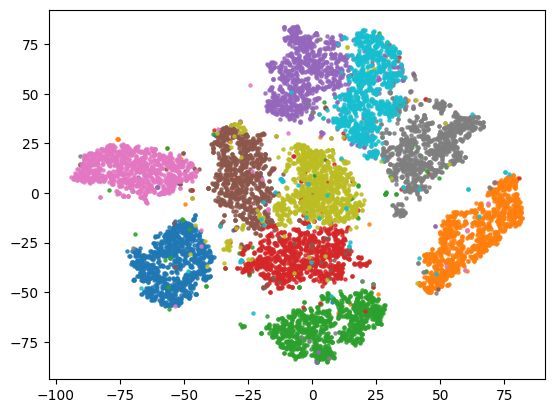

In [11]:
conv_ae_encoding = conv_encoded_data_per_eval[-1]

conv_ae_features = conv_ae_encoding[:, :-1]
labels = conv_ae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_ae_compressed = tsne.fit_transform(X=conv_ae_features)

conv_ae_encoding = np.hstack((conv_ae_compressed, labels))
conv_ae_encoding = pd.DataFrame(conv_ae_encoding, columns=["x", "y", "class"])
conv_ae_encoding = conv_ae_encoding.sort_values(by="class")
conv_ae_encoding["class"] = conv_ae_encoding["class"].astype(int).astype(str)

for grouper, group in conv_ae_encoding.groupby("class"):
    plt.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

### Comparing Reconstructions

Do Convolutions have better reconstruction performance compared to the linear autoencoder?

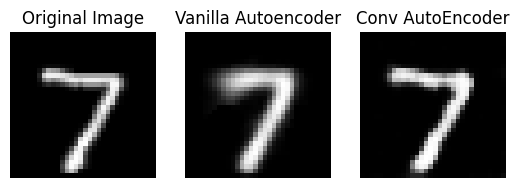

In [12]:
generated_index = 0
image, label = test_set[generated_index]

_, vanilla_reconstructed = vanilla_model(image.unsqueeze(0).to(device))
_, conv_reconstructed = conv_model(image.unsqueeze(0).to(device))

vanilla_reconstructed = vanilla_reconstructed.to("cpu").detach().numpy()
conv_reconstructed = conv_reconstructed.to("cpu").detach().numpy()

fig, ax = plt.subplots(1,3)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original Image")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(vanilla_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("Vanilla Autoencoder")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

ax[2].imshow(conv_reconstructed.squeeze(), cmap="gray")
ax[2].set_title("Conv AutoEncoder")
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].axis("off")


plt.show()


## What about Generating New Images!!

Until now we have only been looking at our Encoder, which takes an image and compresses it down. What about our Decoder? Lets take our Vanilla Autoencoder for example. If we gave it our own two numbers, will it generate any images? Of course! Lets try this exercise, we have our encoded testing data, lets find the median 2 number encodings for each digit and pass them through our decoder to see what it makes!

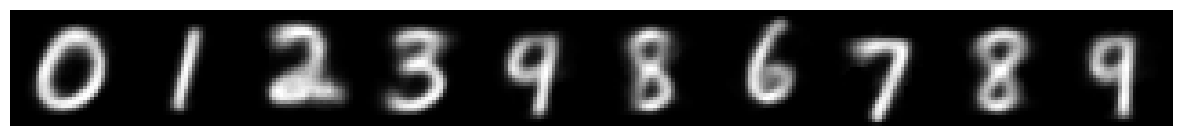

In [13]:
final_embeddings = vanilla_encoded_data[-1]

avg_digit_embeddings = []

for i in range(10):
    avg_embeddings = np.median(final_embeddings[final_embeddings[:, 2] == i][:, :2], axis=0)
    avg_digit_embeddings.append(avg_embeddings)

avg_digit_embeddings = torch.tensor(np.array(avg_digit_embeddings))
pred_images = vanilla_model.forward_dec(avg_digit_embeddings.to("cuda"))

fig, axes = plt.subplots(1,10, figsize=(15,5))
for idx, img in enumerate(pred_images):
    img = img.squeeze().detach().cpu().numpy()
    axes[idx].imshow(img, cmap="gray")
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])
    axes[idx].axis("off")

fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

### Interpolating the Space

So our generations are alright, not the best but maybe model tuning would improve it. But the bigger question is, why don't we use AutoEncoders more for generation? You give it some numbers and it can create what you want! The problem is, the generation space is not compact. Here is again the embedded space from the Vanilla Autoencoder:


<div>
<img src="https://github.com/HarshTomar1234/Machine-and-Deep-Learning-NLP/blob/main/AutoEncoders/imgs/uncompact_vanilla_autoencoder_latents.png?raw=true" width="800"/>
</div>

*Note: might look a bit different from the actual Embeddings above, saved this during one of the training runs*

Notice how the class are totally broken with large amounts of whitespace in between. Many of them also look like they have been stretched out into strands of vector space from the center. Lets try to interpolate the vector space then. What this means is, we will create a grid of values over a range of X and Y values, and the plot what the image generated from a point taken from that space looks like. If we sample points from where the actual encodings are, we should have pretty good results, but if we sample from where there is whitespace between the encodings, the generations will be pretty bad.

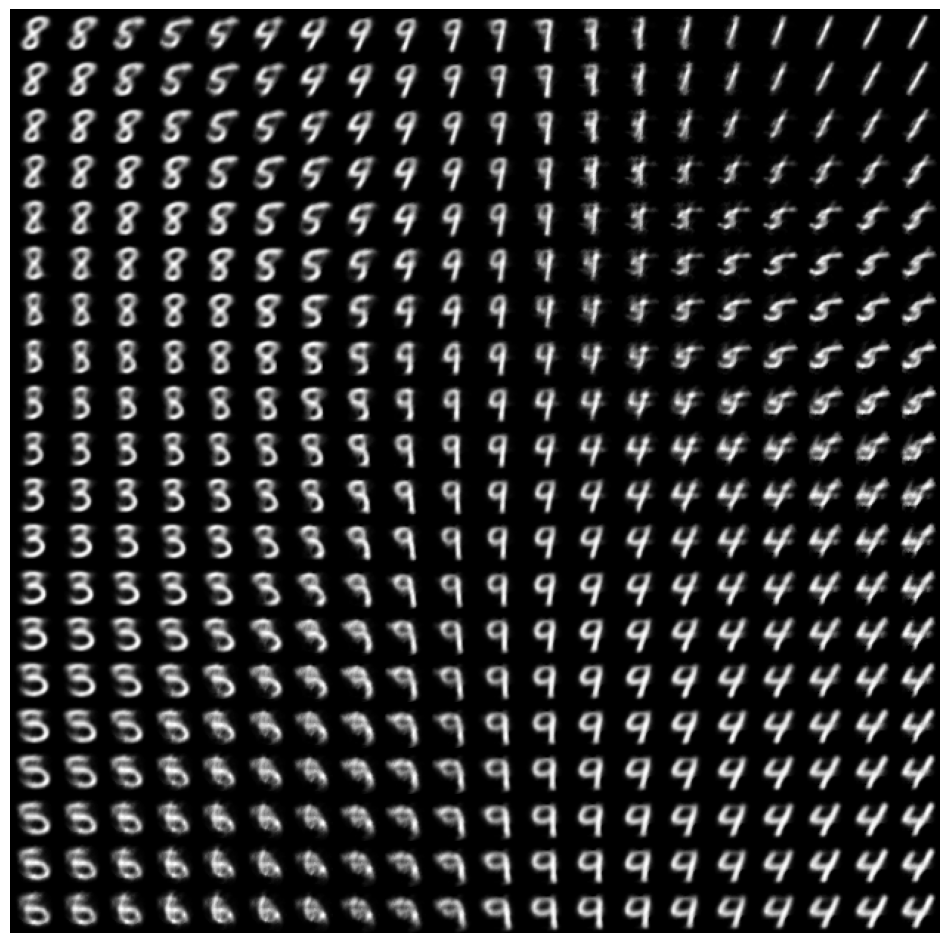

In [16]:
def interpolate_space(model, x_range=(-3,3), y_range=(-3,3), num_steps=20):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    x_space = np.linspace(x_range[0], x_range[1], num_steps)
    y_space = np.linspace(y_range[0], y_range[1], num_steps)

    points = []
    for x in x_space:
        for y in y_space:
            points.append([x,y])

    points = torch.tensor(points, dtype=torch.float32).to(device)

    ### Pass Through Model Decoder and Reshape ###
    dec = model.forward_dec(points).detach().cpu()
    dec = dec.reshape((num_steps,num_steps, *dec.shape[1:]))

    fig, ax = plt.subplots(num_steps,num_steps, figsize=(12,12))

    for x in range(num_steps):
        for y in range(num_steps):
            img = np.array(dec[x,y].permute(1,2,0))
            ax[x,y].imshow(img, cmap="gray")
            ax[x,y].set_xticklabels([])
            ax[x,y].set_yticklabels([])
            ax[x,y].axis("off")

    fig.subplots_adjust(wspace=0, hspace=0)

interpolate_space(vanilla_model)

### Moving to Variational Autoencoders!

**This is Super Important:** Why can't we generate anything from our Convolutional AutoEncoder?

This is because, our convolutional autoencoder compresses our data down to 64 numbers (as a --> 4 x 4 x 4 cube). I have no idea what the vector space for that 64 values looks like. We dont know where the numbers are, or where we can get good generations. We could probe the model and find them but this isnt practical as the model becomes more complex, and it will be hard to find consistent generations. But what if instead of mapping to some arbritrary latent space like we are doing, if we mapped to a specific one with a known distribution?

This is exactly what Variational AutoEncoders do! Not only do they need to perform the reconstruction loss like we have already, but the latent distribution is forced to follow some known probability distribution (typically a Normal distribution). If we know the latent is a Standard Normal distribution, it is very easy to sample from, because we know exactly where the bulk of the data is! In the case of our Convolutional model, we could just pass in gaussian noise to our decoder (in the shape 4 x 4 x 4) and generate away!